In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score
import plotly.express as px

from lightgbm import LGBMClassifier, log_evaluation, LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from optuna.integration import CatBoostPruningCallback
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

In [286]:
df = pd.read_csv('train.csv')
og = pd.read_csv('original.csv')
test_df = pd.read_csv('test.csv')
df.shape, og.shape

((414, 8), (79, 7))

In [287]:
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [288]:
df.isnull().values.any(), og.isnull().values.any()

(False, False)

In [289]:
df.drop('id',axis=1, inplace=True)
test_df.drop('id',axis=1, inplace=True)

In [290]:
# df = pd.concat([df,og],ignore_index=True)
# df.shape

In [291]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [292]:
# def outlier_removal(data , i):
#     q1 = np.quantile(data[i] ,0.25)
#     q3 = np.quantile(data[i] , 0.75)
#     iqr = q3-q1
#     lower_tail = q1 - 1.5*iqr
#     upper_tail = q3 + 1.5*iqr
#     data.drop(data[data[i]> upper_tail].index , inplace = True)
#     data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
# outlier_list = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
# for  i in outlier_list:
#     outlier_removal(df ,i)
# print(df.shape)

In [293]:
# new feats
def new_feats(feat):
    feat_copy = feat.copy()
    feat_copy['Urine_Dilution'] = feat_copy['gravity'] / feat_copy['ph']
    # feat_copy['AcidBase'] = feat_copy['ph'].apply(lambda x: 1 if x < 5 else 0)
    feat_copy['UreaAdjusted'] = feat_copy['urea'] / feat_copy['gravity']
    # feat_copy["ion_product"] = feat_copy["calc"] * feat_copy["urea"]
    # feat_copy["calcium_to_urea_ratio"] = feat_copy["calc"] / feat_copy["urea"]
    # feat_copy["electrolyte_balance"] = feat_copy["cond"] / (10 ** (-feat_copy["ph"]))
    # feat_copy["osmolality_to_sg_ratio"] = feat_copy["osmo"] / feat_copy["gravity"]
    # feat_copy['osmo_density'] = feat_copy['osmo'] * feat_copy['gravity']
    
    # # ******************************************************************
    feat_copy["sum"] = feat_copy['calc']+feat_copy['gravity']-8.20807805874e-3*feat_copy['cond']
    # # # Calculate ammonium concentration (assuming ammonium is not directly measured)
    # feat_copy['ammonium_concentration'] = (feat_copy['gravity'] - 1.010) * (140 - (2 * feat_copy["ph"])) * 1.2
    # # # Calculate phosphate concentration (assuming phosphate is not directly measured)
    # feat_copy['phosphate_concentration'] = (feat_copy['gravity'] - 1.010) * (32 - (0.06 * feat_copy["ph"]))

    # # *****************************************************************
    
    # feat_copy["gravity/ph"] = feat_copy["gravity"] / feat_copy["ph"]
    # feat_copy["osmo/cond"] = feat_copy["osmo"] / feat_copy["cond"]
    # feat_copy["gravity*ph"] = feat_copy["gravity"] * feat_copy["ph"]
    # feat_copy["osmo*urea"] = feat_copy["osmo"] * feat_copy["urea"]
    # feat_copy["cond_urea_ph"] = feat_copy["cond"] * feat_copy["urea"] / feat_copy["ph"]
    # feat_copy["ph*osmo"] = feat_copy["ph"] * feat_copy["osmo"]
    # feat_copy["cond*calc"] = feat_copy["cond"] * feat_copy["calc"]
    # feat_copy["gravity/calc"] = feat_copy["gravity"] / feat_copy["calc"]
    return feat_copy

df_feats = new_feats(df)
test_df = new_feats(test_df)
df.shape, df_feats.shape

((414, 7), (414, 10))

In [294]:
features = [f for f in df_feats.columns if f!= 'target']
features

['gravity',
 'ph',
 'osmo',
 'cond',
 'urea',
 'calc',
 'Urine_Dilution',
 'UreaAdjusted',
 'sum']

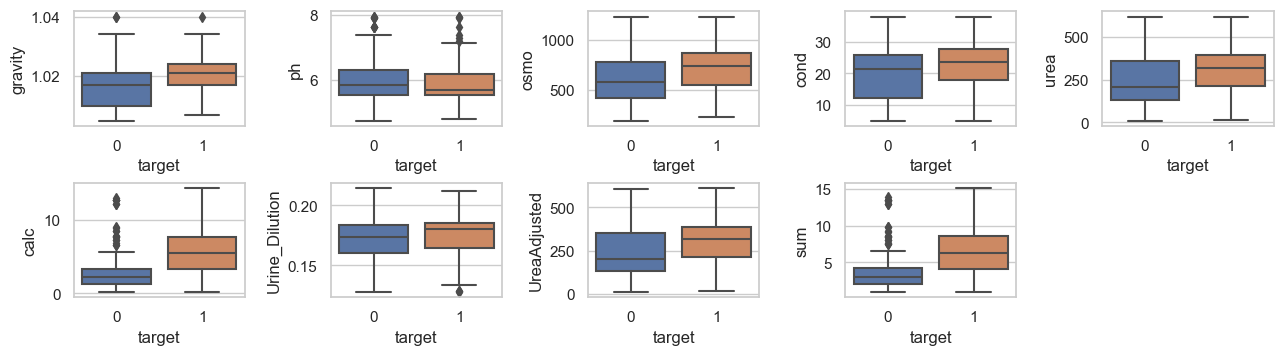

In [295]:
# Set the figure size
plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid")
# Create categorical features subplots
for i, feature in enumerate(features):
    ax = plt.subplot(5, 5, i+1)
    sns.boxplot(x="target", y=feature , data=df_feats, ax=ax)
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=.5, wspace=0.5)

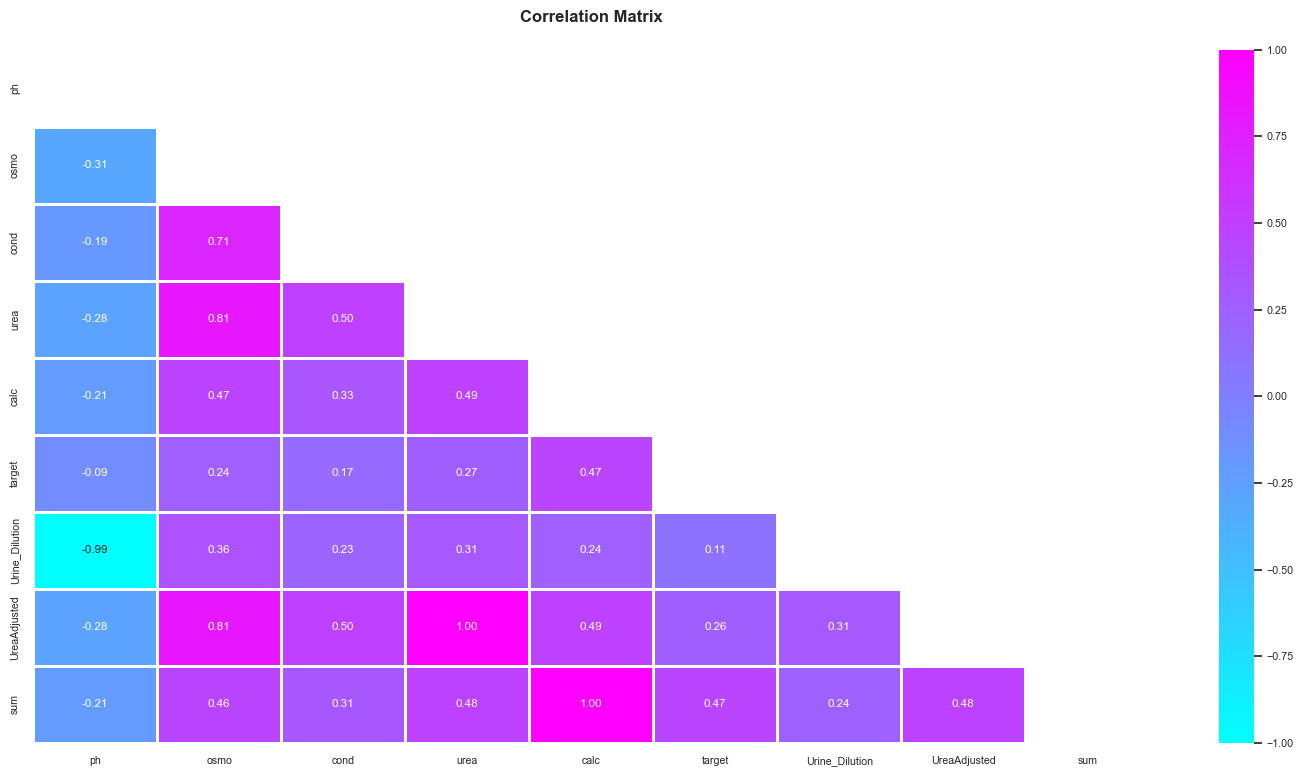

In [296]:
corr = df_feats.iloc[:,1:].corr()

# create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create heatmap
plt.figure(figsize=(18, 9))
# set theme to change overall style
sns.set_theme(style="white", font_scale=0.7)
sns.heatmap(corr, cmap="cool", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=12, weight = 'bold', pad=20)
plt.show()

In [297]:
df_feats.isnull().sum()

gravity           0
ph                0
osmo              0
cond              0
urea              0
calc              0
target            0
Urine_Dilution    0
UreaAdjusted      0
sum               0
dtype: int64

ph is not outlier!!

Modelling

In [298]:
X = df_feats.drop('target',axis=1)
y = df_feats.target

X.shape, y.shape

((414, 9), (414,))

In [299]:
scaler = StandardScaler()
cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,3.259658e-14,1.00121,-1.933988,-0.884026,0.015941,0.615920,3.315823
ph,414.0,-1.244308e-16,1.00121,-1.863584,-0.663242,-0.335876,0.505922,3.093672
osmo,414.0,2.102451e-16,1.00121,-1.981911,-0.837465,0.119262,0.804009,2.493480
cond,414.0,1.566112e-16,1.00121,-2.176745,-0.791125,0.101534,0.820990,2.206609
urea,414.0,1.287215e-16,1.00121,-1.971399,-0.797322,-0.012159,0.780342,2.504767
calc,414.0,-6.865147e-17,1.00121,-1.227424,-0.829136,-0.306383,0.782687,3.181752
Urine_Dilution,414.0,-1.201401e-16,1.00121,-2.540957,-0.593875,0.264887,0.670762,2.351968
UreaAdjusted,414.0,-1.544658e-16,1.00121,-1.985561,-0.801613,-0.015529,0.774589,2.554023
sum,414.0,-7.294219e-17,1.00121,-1.247111,-0.838638,-0.313216,0.787345,3.188504


In [300]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, stratify=y, random_state=123,test_size=0.2)
X_train.shape, X_test.shape

((331, 9), (83, 9))

In [301]:
smote = SMOTE()
X_train_smote , y_train_smote = smote.fit_resample(X_train,y_train)

In [302]:
clf = RandomForestClassifier(random_state=12,class_weight='balanced')
clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'clf score: {clf.score(X_test,y_test)}, AUC: {auc}')

clf score: 0.7710843373493976, AUC: 0.8510575793184489


In [303]:
# get feature importances
importances = clf.feature_importances_

# create feature importance dataframe
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})

# sort by importance descending
feat_imp = feat_imp.sort_values('importance', ascending=False)

# create bar chart with color gradient
fig = px.bar(feat_imp, x='feature', y='importance', color='importance', color_continuous_scale='Blues')

fig.show()

In [304]:
log = LogisticRegression(random_state=12)
log.fit(X_train_smote,y_train_smote)

y_pred = log.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'log score: {log.score(X_test,y_test)}, AUC: {auc}')

log score: 0.8192771084337349, AUC: 0.8225616921269095


In [305]:
lgb = LGBMClassifier(random_state=12, class_weight='balanced',objective='binary')
lgb.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(100)])
y_pred = lgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'lgb score: {lgb.score(X_test,y_test)}, AUC: {auc}')

[100]	valid_0's binary_logloss: 0.572863
lgb score: 0.7469879518072289, AUC: 0.8378378378378378


In [306]:
xgb = XGBClassifier(random_state=12, eval_metric='auc')
xgb.fit(X_train,y_train)
y_pred = xgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'xgb score: {xgb.score(X_test,y_test)}, AUC: {auc}')

xgb score: 0.7469879518072289, AUC: 0.8331374853113984


In [307]:
cat_class = CatBoostClassifier(random_state=12, eval_metric='AUC',early_stopping_rounds=100,verbose=False, use_best_model=True)
cat_class.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat_class.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'cat_class score: {cat_class.score(X_test,y_test)}, AUC: {auc}')

cat_class score: 0.7951807228915663, AUC: 0.8487074030552292


Hyperparameter RandomForest TUning XGB, CAT, LGBM

In [308]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def objective(trial: optuna.Trial) -> float:

    params = {
            'criterion': trial.suggest_categorical('criterion',['gini','entropy','log_loss']),
            'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 3, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 60),
            'max_features': trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'bootstrap': True
        }

    gbm = RandomForestClassifier(**params, random_state=43)

    # smote = SMOTE()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   
    i=0
    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        # train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y
        )

        preds = gbm.predict_proba(valid_x)[:,1]
        rocauc = roc_auc_score(valid_y,preds)
        cv_scores.append(rocauc)
        # i+=1
        # print(f"fold {i} logloss: {logloss}, Accuracy: {accuracy}")
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='RandomForestClassifier',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3), direction="maximize",)
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-18 01:45:39,759] A new study created in memory with name: RandomForestClassifier
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-18 01:45:45,951] Trial 0 finished with value: 0.7848903251077164 and parameters: {'criterion': 'log_loss', 'n_estimators': 1740, 'max_depth': 24, 'min_samples_split': 87, 'min_samples_leaf': 54, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7848903251077164.
[I 2023-04-18 01:45:50,364] Trial 1 finished with value: 0.7963898681289986 and parameters: {'criterion': 'gini', 'n_estimators': 1109, 'max_depth': 13, 'min_samples_split': 85, 'min_samples_leaf': 40, 'max_features': None}. Best is trial 1 with value: 0.7963898681289986.
[I 2023-04-18 01:45:50,767] Trial 2 finished with value: 0.7799125212168689 and parameters: {'criterion': 'gini', 'n_estimators': 113, 'max_depth': 9, 'min_samples_split': 141, 'min_samples_leaf': 34, 'max_features': 'log2'}. Best is trial 1 with value: 0.7963898681289986.
[I 2023-04-18 01:46:03,329] Trial 3 finished with value: 0.8002774513644081 and parameters: {'criterion': 'entropy', 'n_estimators': 2843, 'max_depth': 40, 'min_samples_split

In [309]:
study.best_params

{'criterion': 'entropy',
 'n_estimators': 1829,
 'max_depth': 44,
 'min_samples_split': 150,
 'min_samples_leaf': 53,
 'max_features': None}

In [320]:
rf_params = {'criterion': 'entropy',
 'n_estimators': 1829,
 'max_depth': 44,
 'min_samples_split': 150,
 'min_samples_leaf': 53,
 'max_features': None}

# rf_params = {'criterion': 'gini',
#  'n_estimators': 1726,
#  'max_depth': 50,
#  'min_samples_split': 93,
#  'min_samples_leaf': 8,
#  'max_features': None}

# only train
# rf_params = {'criterion': 'entropy',
#  'n_estimators': 519,
#  'max_depth': 17,
#  'min_samples_split': 126,
#  'min_samples_leaf': 36,
#  'max_features': None}

In [321]:
clf_tune = RandomForestClassifier(random_state=0,**rf_params)
clf_tune.fit(X_train,y_train)

y_pred = clf_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'clf_tune score: {clf_tune.score(X_test,y_test)}, AUC: {auc}')

clf_tune score: 0.7951807228915663, AUC: 0.8422444183313749


In [310]:
import warnings
warnings.filterwarnings(category=UserWarning,action='ignore')
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')

def objective(trial):
    params = {
        'objective':'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample_freq': trial.suggest_int('bagging_freq', 1, 10),
        'metric':'auc'
        
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model = lgbm.LGBMClassifier(**params,random_state=12)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=100,
            verbose=False,
            callbacks=[LightGBMPruningCallback(trial, 'auc')]
        )
        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [311]:
study = optuna.create_study(direction='maximize', study_name="LGBMClassifier", pruner=optuna.pruners.MedianPruner(n_startup_trials=10,n_warmup_steps=50))
study.optimize(objective, n_trials=500, show_progress_bar=True)

[I 2023-04-18 01:50:38,928] A new study created in memory with name: LGBMClassifier
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-04-18 01:50:45,825] Trial 0 finished with value: 0.8054837446141793 and parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'max_depth': 10, 'learning_rate': 0.36780005282723227, 'n_estimators': 907, 'subsample': 0.9902272273674926, 'colsample_bytree': 0.8276907245134363, 'reg_alpha': 4.00350837513673, 'reg_lambda': 9.797037864594474, 'min_child_samples': 81, 'bagging_freq': 2}. Best is trial 0 with value: 0.8054837446141793.
[I 2023-04-18 01:50:46,276] Trial 1 finished with value: 0.8110849980415198 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.06027855222834922, 'n_estimators': 1970, 'subsample': 0.9952882327808514, 'colsample_bytree': 0.8750584476888431, 'reg_alpha': 2.774045152528121, 'reg_lambda': 8.05939683471775, 'min_child_samples': 97, 'bagging_freq': 4}. Best is trial 1 with value: 0.8110849980415198.
[I 2023-04-18 01:50:46,581] Trial 2 finished with value: 0.8027989946468207 and parameters: {'boosting_type': 'gbdt'

In [312]:
print(f"\tBest value (rocauc): {study.best_value:.5f}")
print(f"\tBest params:")
print(study.best_params)

	Best value (rocauc): 0.83311
	Best params:
{'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 9, 'learning_rate': 0.09875606616658275, 'n_estimators': 1353, 'subsample': 0.5067650215542424, 'colsample_bytree': 0.5841256905816004, 'reg_alpha': 0.001707892296869521, 'reg_lambda': 2.158700770564195, 'min_child_samples': 33, 'bagging_freq': 6}


In [322]:
lgb_params = {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 9, 'learning_rate': 0.09875606616658275, 'n_estimators': 1353, 'subsample': 0.5067650215542424, 'colsample_bytree': 0.5841256905816004, 'reg_alpha': 0.001707892296869521, 'reg_lambda': 2.158700770564195, 'min_child_samples': 33, 'bagging_freq': 6}

In [323]:
lgb_tune = LGBMClassifier(random_state=12, **lgb_params)
lgb_tune.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(1000)])
y_pred = lgb_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'lgb_tune score: {lgb_tune.score(X_test,y_test)}, AUC: {auc}')

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1000]	valid_0's binary_logloss: 0.552298
lgb_tune score: 0.7590361445783133, AUC: 0.8307873090481787


In [313]:
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

def objective(trial):
    params = {
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'eta': trial.suggest_float('eta', 1e-5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        #  only for imbalance
        # 'max_delta_step': trial.suggest_categorical('max_delta_step',[0,5,10,30,30,40,50]) 
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    model = xgb.XGBClassifier(**params,random_state=43)
    cv_scores = np.empty(5)
    i=0
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)[:, 1]
        rocauc = roc_auc_score(y_test,preds)
        cv_scores[idx] = rocauc
    return np.mean(cv_scores)

In [314]:
study = optuna.create_study(direction='maximize', study_name='XGB_classifier')
study.optimize(objective, n_trials=700, show_progress_bar=True)
print(study.best_params)

[I 2023-04-18 02:01:31,023] A new study created in memory with name: XGB_classifier
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/700 [00:00<?, ?it/s]

[I 2023-04-18 02:01:31,289] Trial 0 finished with value: 0.7994010314662487 and parameters: {'max_depth': 11, 'eta': 0.5863122173207994, 'min_child_weight': 10, 'gamma': 0.5536733489247648, 'subsample': 0.9722937833837734, 'colsample_bytree': 0.9341801205752909, 'reg_alpha': 6.784731772450579, 'reg_lambda': 1.2390141528999425}. Best is trial 0 with value: 0.7994010314662487.
[I 2023-04-18 02:01:31,518] Trial 1 finished with value: 0.7882882882882882 and parameters: {'max_depth': 10, 'eta': 0.2681015937345973, 'min_child_weight': 8, 'gamma': 0.020792741924969466, 'subsample': 0.9649964547469982, 'colsample_bytree': 0.4458509838196979, 'reg_alpha': 0.00874883321545618, 'reg_lambda': 4.769826912827064}. Best is trial 0 with value: 0.7994010314662487.
[I 2023-04-18 02:01:31,726] Trial 2 finished with value: 0.8014264264264265 and parameters: {'max_depth': 9, 'eta': 0.02853312657246329, 'min_child_weight': 2, 'gamma': 0.3720061598266562, 'subsample': 0.25390610934087354, 'colsample_bytree':

In [315]:
study.best_params

{'max_depth': 13,
 'eta': 0.309522133570492,
 'min_child_weight': 1,
 'gamma': 0.21718979260412968,
 'subsample': 0.8537690388780769,
 'colsample_bytree': 0.5294005922363123,
 'reg_alpha': 7.362673006266809,
 'reg_lambda': 8.189311348773286}

In [328]:

xgb_params = {'max_depth': 13,
 'eta': 0.309522133570492,
 'min_child_weight': 1,
 'gamma': 0.21718979260412968,
 'subsample': 0.8537690388780769,
 'colsample_bytree': 0.5294005922363123,
 'reg_alpha': 7.362673006266809,
 'reg_lambda': 8.189311348773286}

# xgb_params = {'max_depth': 11,
#  'eta': 0.10288325096223679,
#  'min_child_weight': 3,
#  'gamma': 0.042977474200641,
#  'subsample': 0.7888537294776343,
#  'colsample_bytree': 0.5732487688037096,
#  'reg_alpha': 1.5500257999897522,
#  'reg_lambda': 7.184563346426339}


# only train data no og
# xgb_params = {
#     'max_depth': 8,
#     'eta': 0.16305044455164977,
#     'min_child_weight': 18,
#     'gamma': 0.11712334392622112,
#     'subsample': 0.9920485127038325,
#     'colsample_bytree': 0.765250387587039,
#     'reg_alpha': 0.008788883682020746,
#     'reg_lambda': 0.018141543669711144
#     }

# xgb_params = {'max_depth': 1,
#  'eta': 0.11714605952941523,
#  'min_child_weight': 2,
#  'gamma': 0.2610698252586401,
#  'subsample': 0.5869827322228711,
#  'colsample_bytree': 0.7170351315920238,
#  'reg_alpha': 0.5785016043684591,
#  'reg_lambda': 0.06584531912227781}


In [329]:
xgb_tune = XGBClassifier(random_state=43, eval_metric='auc',**xgb_params)
xgb_tune.fit(X_train,y_train)
y_pred = xgb_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'xgb_tune score: {xgb_tune.score(X_test,y_test)}, AUC: {auc}')

xgb_tune score: 0.7951807228915663, AUC: 0.8545828437132785


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')


def objective(trial: optuna.Trial) -> float:
    data, target = X,y
    # train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        "iterations": trial.suggest_int('iterations',400,1000),
        "random_strength": trial.suggest_float("random_strength", 0.001, 10, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        'random_seed': 123,
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param, use_best_model=True)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   

    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )

        # evoke pruning manually.
        pruning_callback.check_pruned()

        preds = gbm.predict(valid_x)
        pred_proba = gbm.predict_proba(valid_x)[:,1]
        rocauc = roc_auc_score(valid_y,pred_proba)
        cv_scores.append(rocauc)
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='CatClassifier',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=50, n_startup_trials=3), direction="maximize",
        load_if_exists=True
    )
    study.optimize(objective, n_trials=2000,timeout=300, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [319]:
study.best_params

{'objective': 'Logloss',
 'learning_rate': 0.3436886190350353,
 'iterations': 547,
 'random_strength': 0.024165131721076753,
 'colsample_bylevel': 0.07980678786185005,
 'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.17692446811950804}

In [331]:
cb_params = {'objective': 'Logloss',
 'learning_rate': 0.3436886190350353,
 'iterations': 547,
 'random_strength': 0.024165131721076753,
 'colsample_bylevel': 0.07980678786185005,
 'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.17692446811950804,
 "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        'random_seed': 123,
 }

# cb_params = {'objective': 'Logloss',
#  'learning_rate': 0.554864229676231,
#  'iterations': 500,
#  'random_strength': 0.0030029558035803683,
#  'colsample_bylevel': 0.07737227002881103,
#  'depth': 8,
#  'boosting_type': 'Ordered',
#  'bootstrap_type': 'Bernoulli',
#  'subsample': 0.1695726075477245}

In [332]:
cat_tune = CatBoostClassifier(early_stopping_rounds=100,verbose=False, use_best_model=True,**cb_params)
cat_tune.fit(X_train,y_train, eval_set=(X_test,y_test))
y_pred = cat_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'cat_tune score: {cat_tune.score(X_test,y_test)}, AUC: {auc}')

cat_tune score: 0.7831325301204819, AUC: 0.8469447708578144


Regressors

In [333]:
clf = RandomForestRegressor(random_state=12)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'clf score: {clf.score(X_test,y_test)}, AUC: {auc}')

clf score: 0.3826740893066979, AUC: 0.8575205640423031


In [334]:
# get feature importances
importances = clf.feature_importances_

# create feature importance dataframe
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})

# sort by importance descending
feat_imp = feat_imp.sort_values('importance', ascending=False)

# create bar chart with color gradient
fig = px.bar(feat_imp, x='feature', y='importance', color='importance', color_continuous_scale='Blues')

fig.show()

In [335]:
lgb = LGBMRegressor(random_state=12,objective='RMSE')
lgb.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(100)])
y_pred = lgb.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'lgb score: {lgb.score(X_test,y_test)}, AUC: {auc}')

[100]	valid_0's rmse: 0.436786
lgb score: 0.22779086677317884, AUC: 0.8055229142185664


In [336]:
xgb = XGBRegressor(random_state=12, eval_metric='rmse')
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'xgb score: {xgb.score(X_test,y_test)}, AUC: {auc}')

xgb score: 0.3002689582877951, AUC: 0.81903642773208


In [337]:
cat = CatBoostRegressor(random_state=12, eval_metric='RMSE',early_stopping_rounds=100,verbose=False, use_best_model=True)
cat.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'cat score: {cat.score(X_test,y_test)}, AUC: {auc}')

cat score: 0.37022473247610355, AUC: 0.8519388954171565


In [338]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def objective(trial: optuna.Trial) -> float:

    params = {
            'criterion': trial.suggest_categorical('criterion',['squared_error']),
            'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 3, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 60),
            'max_features': trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'bootstrap': True
        }

    gbm = RandomForestRegressor(**params, random_state=43)

    # smote = SMOTE()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   
    i=0
    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        # train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y
        )

        preds = gbm.predict(valid_x)
        rocauc = roc_auc_score(valid_y,preds)
        cv_scores.append(rocauc)
        # i+=1
        # print(f"fold {i} logloss: {logloss}, Accuracy: {accuracy}")
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='RandomForestRegressor',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3), direction="maximize",)
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-18 02:12:33,622] A new study created in memory with name: RandomForestRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-18 02:12:40,194] Trial 0 finished with value: 0.7980643687165426 and parameters: {'criterion': 'squared_error', 'n_estimators': 2154, 'max_depth': 25, 'min_samples_split': 84, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7980643687165426.
[I 2023-04-18 02:12:48,466] Trial 1 finished with value: 0.7938666927797363 and parameters: {'criterion': 'squared_error', 'n_estimators': 2383, 'max_depth': 34, 'min_samples_split': 18, 'min_samples_leaf': 41, 'max_features': None}. Best is trial 0 with value: 0.7980643687165426.
[I 2023-04-18 02:12:51,824] Trial 2 finished with value: 0.7854876615746181 and parameters: {'criterion': 'squared_error', 'n_estimators': 1124, 'max_depth': 46, 'min_samples_split': 19, 'min_samples_leaf': 54, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7980643687165426.
[I 2023-04-18 02:12:56,634] Trial 3 finished with value: 0.7962641989815904 and parameters: {'criterion': 'squared_error', 'n_estimators': 1434, 'max_d

In [339]:
study.best_params

{'criterion': 'squared_error',
 'n_estimators': 74,
 'max_depth': 40,
 'min_samples_split': 86,
 'min_samples_leaf': 51,
 'max_features': None}

In [352]:
# only train
rf_params_reg = {'criterion': 'squared_error',
 'n_estimators': 304,
 'max_depth': 28,
 'min_samples_split': 84,
 'min_samples_leaf': 8,
 'max_features': None}

In [353]:
clf_tune_reg = RandomForestRegressor(random_state=43,**rf_params_reg)
clf_tune_reg.fit(X_train,y_train)

y_pred = clf_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'clf_tune_reg score: {clf_tune_reg.score(X_test,y_test)}, AUC: {auc}')

clf_tune_reg score: 0.36980640130751385, AUC: 0.8531139835487663


In [340]:
import warnings
warnings.filterwarnings(category=UserWarning,action='ignore')
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')

def objective(trial):
    params = {
        'objective':'rmse',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample_freq': trial.suggest_int('bagging_freq', 1, 10),
        'metric':'auc'
        
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model = lgbm.LGBMRegressor(**params,random_state=12)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=100,
            verbose=False,
            callbacks=[LightGBMPruningCallback(trial, 'auc')]
        )
        preds = model.predict(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [341]:
study = optuna.create_study(direction='maximize', study_name="LGBMRegressor", pruner=optuna.pruners.MedianPruner(n_startup_trials=10,n_warmup_steps=50))
study.optimize(objective, n_trials=500, show_progress_bar=True)

[I 2023-04-18 02:15:44,626] A new study created in memory with name: LGBMRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-04-18 02:15:44,870] Trial 0 finished with value: 0.5 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 7, 'learning_rate': 0.12671976059354073, 'n_estimators': 239, 'subsample': 0.10354335459134212, 'colsample_bytree': 0.9869953953922188, 'reg_alpha': 3.0599093784461213, 'reg_lambda': 3.8148318340910015, 'min_child_samples': 97, 'bagging_freq': 9}. Best is trial 0 with value: 0.5.
[I 2023-04-18 02:15:45,554] Trial 1 finished with value: 0.7979599164381772 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 4, 'learning_rate': 0.0601512862804205, 'n_estimators': 1541, 'subsample': 0.6262705867509223, 'colsample_bytree': 0.22847813041179274, 'reg_alpha': 8.92089651280849, 'reg_lambda': 1.0662133924630917, 'min_child_samples': 61, 'bagging_freq': 7}. Best is trial 1 with value: 0.7979599164381772.
[I 2023-04-18 02:15:45,675] Trial 2 finished with value: 0.7598511555033294 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_d

In [354]:
print(f"\tBest value (rocauc): {study.best_value:.5f}")
print(f"\tBest params:")
print(study.best_params)

	Best value (rocauc): 0.82980
	Best params:
{'objective': 'RMSE', 'learning_rate': 0.4496251204536551, 'iterations': 961, 'random_strength': 0.04656928167873827, 'colsample_bylevel': 0.09039642431655907, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.14548207792089368}


In [359]:
lgb_params_reg = {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 10, 'learning_rate': 0.34010477573600073, 'n_estimators': 492, 'subsample': 0.697480623357571, 'colsample_bytree': 0.25888611796340116, 'reg_alpha': 2.156656841972668, 'reg_lambda': 4.964260499545862, 'min_child_samples': 13, 'bagging_freq': 6}

In [360]:
lgb_tune_reg = LGBMRegressor(random_state=12, **lgb_params_reg)
lgb_tune_reg.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(1000)])
y_pred = lgb_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'lgb_tune_reg score: {lgb_tune_reg.score(X_test,y_test)}, AUC: {auc}')

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
lgb_tune_reg score: 0.30297379597219043, AUC: 0.8401880141010576


In [343]:
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

def objective(trial):
    params = {
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'eta': trial.suggest_float('eta', 1e-5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        #  only for imbalance
        # 'max_delta_step': trial.suggest_categorical('max_delta_step',[0,5,10,30,30,40,50]) 
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    model = xgb.XGBRegressor(**params,random_state=43)
    cv_scores = np.empty(5)
    i=0
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict(X_test)
        rocauc = roc_auc_score(y_test,preds)
        cv_scores[idx] = rocauc
    return np.mean(cv_scores)

In [344]:
study = optuna.create_study(direction='maximize', study_name='XGBRegressor')
study.optimize(objective, n_trials=500, show_progress_bar=True)
print(study.best_params)

[I 2023-04-18 02:23:59,864] A new study created in memory with name: XGBRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-04-18 02:24:00,125] Trial 0 finished with value: 0.8081962397179788 and parameters: {'max_depth': 2, 'eta': 0.03556479416430028, 'min_child_weight': 10, 'gamma': 0.16033045954109895, 'subsample': 0.37234780967437253, 'colsample_bytree': 0.9391160173150067, 'reg_alpha': 8.814183410500057, 'reg_lambda': 0.6542947520502517}. Best is trial 0 with value: 0.8081962397179788.
[I 2023-04-18 02:24:00,391] Trial 1 finished with value: 0.7736519127823476 and parameters: {'max_depth': 20, 'eta': 0.7979246861114961, 'min_child_weight': 10, 'gamma': 0.1215657544078716, 'subsample': 0.7001282940550385, 'colsample_bytree': 0.9068180421239964, 'reg_alpha': 2.570780342594835, 'reg_lambda': 1.6643966850619882}. Best is trial 0 with value: 0.8081962397179788.
[I 2023-04-18 02:24:00,641] Trial 2 finished with value: 0.7850551638595116 and parameters: {'max_depth': 13, 'eta': 0.22555987777855924, 'min_child_weight': 5, 'gamma': 0.8307034827941376, 'subsample': 0.509782866282442, 'colsample_bytree': 

In [345]:
study.best_params

{'max_depth': 16,
 'eta': 0.3326992811176362,
 'min_child_weight': 10,
 'gamma': 0.018142710851430207,
 'subsample': 0.6409535531739023,
 'colsample_bytree': 0.20196311374771742,
 'reg_alpha': 4.80880827157256,
 'reg_lambda': 7.584005150079647}

In [367]:

#
xgb_params_reg = {'max_depth': 16,
 'eta': 0.3326992811176362,
 'min_child_weight': 10,
 'gamma': 0.018142710851430207,
 'subsample': 0.6409535531739023,
 'colsample_bytree': 0.20196311374771742,
 'reg_alpha': 4.80880827157256,
 'reg_lambda': 7.584005150079647}

# xgb_params_reg = {'max_depth': 2,
#  'eta': 0.3656881066898855,
#  'min_child_weight': 7,
#  'gamma': 0.11842134003601712,
#  'subsample': 0.5801912956740369,
#  'colsample_bytree': 0.038243813821904095,
#  'reg_alpha': 1.6334308506833513,
#  'reg_lambda': 5.406130734941781}


# only train data no og
# xgb_params = {
#     'max_depth': 8,
#     'eta': 0.16305044455164977,
#     'min_child_weight': 18,
#     'gamma': 0.11712334392622112,
#     'subsample': 0.9920485127038325,
#     'colsample_bytree': 0.765250387587039,
#     'reg_alpha': 0.008788883682020746,
#     'reg_lambda': 0.018141543669711144
#     }

# xgb_params = {'max_depth': 1,
#  'eta': 0.11714605952941523,
#  'min_child_weight': 2,
#  'gamma': 0.2610698252586401,
#  'subsample': 0.5869827322228711,
#  'colsample_bytree': 0.7170351315920238,
#  'reg_alpha': 0.5785016043684591,
#  'reg_lambda': 0.06584531912227781}


In [368]:
xgb_tune_reg = XGBRegressor(random_state=43, eval_metric='auc',**xgb_params_reg)
xgb_tune_reg.fit(X_train,y_train)
y_pred = xgb_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'xgb_tune_reg score: {xgb_tune_reg.score(X_test,y_test)}, AUC: {auc}')

xgb_tune_reg score: 0.35220872470350306, AUC: 0.8396004700352527


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')


def objective(trial: optuna.Trial) -> float:
    data, target = X,y
    # train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)

    param = {
        "objective": trial.suggest_categorical("objective", ["RMSE"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        "iterations": trial.suggest_int('iterations',400,1000),
        "random_strength": trial.suggest_float("random_strength", 0.001, 10, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        'random_seed': 123,
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostRegressor(**param, use_best_model=True)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   

    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )

        # evoke pruning manually.
        pruning_callback.check_pruned()

        preds = gbm.predict(valid_x)
        pred_proba = gbm.predict(valid_x)
        rocauc = roc_auc_score(valid_y,pred_proba)
        cv_scores.append(rocauc)
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='CatClassifier',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=50, n_startup_trials=3), direction="maximize",
        load_if_exists=True
    )
    study.optimize(objective, n_trials=2000,timeout=300, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [370]:
study.best_params

{'objective': 'RMSE',
 'learning_rate': 0.4496251204536551,
 'iterations': 961,
 'random_strength': 0.04656928167873827,
 'colsample_bylevel': 0.09039642431655907,
 'depth': 10,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.14548207792089368}

In [373]:
cb_params_reg = {'objective': 'RMSE',
 'learning_rate': 0.4496251204536551,
 'iterations': 961,
 'random_strength': 0.04656928167873827,
 'colsample_bylevel': 0.09039642431655907,
 'depth': 10,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.14548207792089368,
 "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        'random_seed': 123,
 }



# cb_params_reg = {'objective': 'RMSE',
#  'learning_rate': 0.4496251204536551,
#  'iterations': 961,
#  'random_strength': 0.04656928167873827,
#  'colsample_bylevel': 0.09039642431655907,
#  'depth': 10,
#  'boosting_type': 'Plain',
#  'bootstrap_type': 'Bernoulli',
#  'subsample': 0.14548207792089368}

In [374]:
cat_tune_reg = CatBoostRegressor(early_stopping_rounds=100,verbose=False, use_best_model=True,**cb_params_reg)
cat_tune_reg.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'cat_tune_reg score: {cat_tune_reg.score(X_test,y_test)}, AUC: {auc}')

cat_tune_reg score: 0.35743689742489715, AUC: 0.8460634547591069


Ensembling

In [375]:
y_pred_cat = cat_tune.predict_proba(X_test)[:,1] 
y_pred_lgb = lgb_tune.predict_proba(X_test)[:,1]
y_pred_clf = clf_tune.predict_proba(X_test)[:,1]
y_pred_xgb = xgb_tune.predict_proba(X_test)[:,1]
y_pred_log = log.predict_proba(X_test)[:,1]

In [376]:
def clipped_val(any_pred):
    any_pred = np.clip(any_pred, a_min=0, a_max=1)
    # print('Done!')
    return any_pred

In [377]:
y_pred_cat_reg = cat.predict(X_test)
y_pred_lgb_reg = lgb_tune_reg.predict(X_test)
y_pred_clf_reg = clf_tune_reg.predict(X_test)
y_pred_xgb_reg = xgb_tune_reg.predict(X_test)

In [378]:
y_pred_cat_reg = clipped_val(y_pred_cat_reg)
y_pred_lgb_reg = clipped_val(y_pred_lgb_reg)
y_pred_clf_reg = clipped_val(y_pred_clf_reg)
y_pred_xgb_reg = clipped_val(y_pred_xgb_reg)

In [381]:

def objective(trial):
    cat_cl_weight = trial.suggest_float('cat_cl_weight', 0, 1)
    lgb_cl_weight = trial.suggest_float('lgb_cl_weight', 0, 1)
    rf_cl_weight = trial.suggest_float('rf_cl_weight', 0, 1)
    xgb_cl_weight = trial.suggest_float('xgb_cl_weight', 0, 1)
    cat_reg_weight = trial.suggest_float('cat_reg_weight', 0, 1)
    # lgb_reg_weight = trial.suggest_float('lgb_reg_weight', 0, 1)
    clf_reg_weight = trial.suggest_float('clf_reg_weight', 0, 1)
    xgb_reg_weight = trial.suggest_float('xgb_reg_weight', 0, 1)
    
    
    # e = trial.suggest_float('e',0,1)
    
    # Normalize the weights
    total_weight = cat_cl_weight + lgb_cl_weight + rf_cl_weight + xgb_cl_weight + cat_reg_weight + clf_reg_weight + xgb_reg_weight
    cat_cl_weight = cat_cl_weight / total_weight
    lgb_cl_weight = lgb_cl_weight / total_weight
    rf_cl_weight = rf_cl_weight / total_weight
    xgb_cl_weight = xgb_cl_weight / total_weight
    cat_reg_weight = cat_reg_weight / total_weight
    # lgb_reg_weight = lgb_reg_weight / total_weight
    clf_reg_weight = clf_reg_weight / total_weight
    xgb_reg_weight = xgb_reg_weight / total_weight

    
    # Create the ensemble model
    y_pred_ensemble =   (cat_cl_weight * y_pred_cat) + (lgb_cl_weight * y_pred_lgb) + (rf_cl_weight * y_pred_clf) + (xgb_cl_weight * y_pred_xgb) + \
                        (cat_reg_weight * y_pred_cat_reg) + (clf_reg_weight * y_pred_clf_reg) + (xgb_reg_weight * y_pred_xgb_reg) 
    
    y_pred_ensemble = clipped_val(y_pred_ensemble)

    # Calculate the AUC score for the ensemble model
    score = roc_auc_score(y_test, y_pred_ensemble)
    
    return score

# Run the optimization
study = optuna.create_study(direction='maximize',study_name='Ensemble Weight Optimizer')
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# Get the best weights
best_weights = study.best_params

[I 2023-04-18 02:44:16,942] A new study created in memory with name: Ensemble Weight Optimizer
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-04-18 02:44:16,954] Trial 0 finished with value: 0.8601645123384254 and parameters: {'cat_cl_weight': 0.6184837225259627, 'lgb_cl_weight': 0.17161683900288827, 'rf_cl_weight': 0.9875959740294943, 'xgb_cl_weight': 0.49485084254275, 'cat_reg_weight': 0.4645367136676716, 'clf_reg_weight': 0.5162897241234967, 'xgb_reg_weight': 0.1421420944104672}. Best is trial 0 with value: 0.8601645123384254.
[I 2023-04-18 02:44:16,956] Trial 1 finished with value: 0.8595769682726205 and parameters: {'cat_cl_weight': 0.2102844950041466, 'lgb_cl_weight': 0.10625016364855189, 'rf_cl_weight': 0.253660738114759, 'xgb_cl_weight': 0.398086346721101, 'cat_reg_weight': 0.45085470133867545, 'clf_reg_weight': 0.6044467436518619, 'xgb_reg_weight': 0.028048393678703598}. Best is trial 0 with value: 0.8601645123384254.
[I 2023-04-18 02:44:16,960] Trial 2 finished with value: 0.8484136310223268 and parameters: {'cat_cl_weight': 0.9208028333169952, 'lgb_cl_weight': 0.05161714558800634, 'rf_cl_weight': 0.5151343

In [382]:
study.best_params

{'cat_cl_weight': 0.05826347092199821,
 'lgb_cl_weight': 0.30894430956155106,
 'rf_cl_weight': 0.6811784008401852,
 'xgb_cl_weight': 0.9664780971550061,
 'cat_reg_weight': 0.22407763649020204,
 'clf_reg_weight': 0.545582388008687,
 'xgb_reg_weight': 0.04734351054607897}

since lgb_reg = 0.004 removing.

In [383]:
cat_cl_weight= 0.05826347092199821
lgb_cl_weight= 0.30894430956155106
rf_cl_weight= 0.6811784008401852
xgb_cl_weight= 0.9664780971550061
cat_reg_weight= 0.22407763649020204
clf_reg_weight= 0.545582388008687
xgb_reg_weight= 0.04734351054607897

In [384]:
test_df = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
test_df.drop('id',axis=1,inplace=True)
test_df.head()

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36


In [385]:
test_df = new_feats(test_df)
test_df.shape

(276, 9)

In [386]:
cols = test_df.columns
test_df = scaler.fit_transform(test_df)
test_df = pd.DataFrame(test_df, columns=cols)
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,276.0,2.159303e-14,1.001817,-2.033019,-0.660358,0.102231,0.750432,2.389999
ph,276.0,1.930823e-16,1.001817,-1.714915,-0.675384,-0.345374,0.446649,3.301234
osmo,276.0,-1.544658e-16,1.001817,-1.983150,-0.842998,0.013176,0.798356,2.463021
cond,276.0,-3.861645e-16,1.001817,-2.289264,-0.611857,0.233665,0.779163,2.197458
urea,276.0,-6.436076e-18,1.001817,-1.611678,-0.835495,0.007535,0.772576,2.518058
calc,276.0,1.383756e-16,1.001817,-1.267254,-0.826925,-0.274690,0.474599,3.329032
Urine_Dilution,276.0,1.393410e-15,1.001817,-2.760377,-0.590917,0.324100,0.701257,2.221202
UreaAdjusted,276.0,-4.827057e-17,1.001817,-1.622390,-0.837251,0.009415,0.766434,2.519396
sum,276.0,3.089316e-16,1.001817,-1.251087,-0.820966,-0.269155,0.477292,3.351771


In [388]:
y_pred_test_cat = cat_tune.predict_proba(test_df)[:,1]
y_pred_test_clf = clf_tune.predict_proba(test_df)[:,1]
y_pred_test_lgb = lgb_tune.predict_proba(test_df)[:,1]
y_pred_test_xgb = xgb_tune.predict_proba(test_df)[:,1]

y_pred_test_cat_reg = cat_tune_reg.predict(test_df)
y_pred_test_xgb_reg = xgb_tune_reg.predict(test_df)
y_pred_test_clf_reg = clf_tune_reg.predict(test_df)

y_pred_test_cat_reg = clipped_val(y_pred_test_cat_reg)
y_pred_test_xgb_reg = clipped_val(y_pred_test_xgb_reg)
y_pred_test_clf_reg = clipped_val(y_pred_test_clf_reg)

In [389]:
y_pred_test_ensemble = (cat_cl_weight * y_pred_test_cat) + (lgb_cl_weight * y_pred_test_lgb) + (rf_cl_weight * y_pred_test_clf) + \
                        (cat_reg_weight * y_pred_test_cat_reg) + (clf_reg_weight * y_pred_test_clf_reg) + (xgb_reg_weight * y_pred_test_xgb_reg)
y_pred_test_ensemble = clipped_val(y_pred_test_ensemble)

In [390]:
len(y_pred_test_ensemble)

276

In [391]:
sample.head()

,id,target
0,414,0.5
1,415,0.5
2,416,0.5
3,417,0.5
4,418,0.5


In [392]:
sub = pd.DataFrame({'id':sample.id,'target':y_pred_test_ensemble})
sub.to_csv('submission_ensemble_bakwas_onlytrain.csv',index=False)
sub.head()

,id,target
0,414,0.461161
1,415,0.663107
2,416,1.000000
3,417,0.936954
4,418,0.418026
